### Recommendation system

In [64]:
import pandas as pd
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [86]:
imb = pd.read_csv('imb.csv') 
topSpain = pd.read_csv('topSpain.csv')
topGlobal = pd.read_csv('topGlobal.csv')

In [66]:
imb_id = imb['id'].values # Extract my playlist id. We need to concatenate all the songs to create a common vector length to calculate cosine similarity
topSpain_id = topSpain['id'].values
topGlobal_id = topGlobal['id'].values
allSongs = pd.concat([imb, topSpain, topGlobal])
allSongs = allSongs.drop_duplicates(subset='id') #Remove duplicates from all three playlists
allSongs.head(3)

,id,name,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,genres
0,2z9YkcLojiOE7Eu2p9lPZR,Normal,0.0397,0.712,0.557,0.000000,4,0.270,-4.861,0,0.1150,170.079,0.594,"['colombian pop', 'pop reggaeton', 'reggaeton'..."
1,6ipzb1kHhWIxp1tS0vwqPl,Ferxxo 100,0.2520,0.701,0.568,0.000000,8,0.153,-3.389,0,0.0670,164.062,0.577,"['colombian pop', 'pop reggaeton', 'reggaeton'..."
2,4srcMdbm2qzVG98tJajHxp,Pantysito,0.1360,0.830,0.739,0.000002,7,0.162,-5.395,0,0.0627,97.993,0.631,"['reggaeton', 'trap latino', 'urbano latino', ..."


In [67]:
allSongs.iloc[0,-1][0] #We see that genres is actually a string that looks like a list. Convert them to list.

'['

In [68]:
allSongs['genres'] = allSongs['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])
allSongs.head(3)

,id,name,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,genres
0,2z9YkcLojiOE7Eu2p9lPZR,Normal,0.0397,0.712,0.557,0.000000,4,0.270,-4.861,0,0.1150,170.079,0.594,"[colombian_pop, pop_reggaeton, reggaeton, regg..."
1,6ipzb1kHhWIxp1tS0vwqPl,Ferxxo 100,0.2520,0.701,0.568,0.000000,8,0.153,-3.389,0,0.0670,164.062,0.577,"[colombian_pop, pop_reggaeton, reggaeton, regg..."
2,4srcMdbm2qzVG98tJajHxp,Pantysito,0.1360,0.830,0.739,0.000002,7,0.162,-5.395,0,0.0627,97.993,0.631,"[reggaeton, trap_latino, urbano_latino, colomb..."


In [69]:

def feature_set(playlist): 
    """
    This is the funciton that will create the the feature set given our genres and audio features. We will use a Tf-Idf approach for the
    genres feature which will create a column for each different genre. We will also scale float columns, which are the audio feature ones.
    """
    # Tf-Idf genres
    tf_idf = TfidfVectorizer()
    tfidf_matrix =  tf_idf.fit_transform(playlist['genres'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = [i for i in tf_idf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #Scale floats
    float_cols = playlist.dtypes[playlist.dtypes == 'float64'].index.values
    floats = playlist[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns)

    final = pd.concat([genre_df, floats_scaled], axis=1)
    final['id'] = playlist['id'].values
    final['name'] = playlist['name'].values
    return final

In [70]:
allSongs_feature_set = feature_set(allSongs)

/Users/beltranvalero/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Create playlist single vector

In [71]:
"""
The approach we will take will be to first create a single vector from our playlist and using cosine similarity, 
measure the similarity bewteen our vector and the vectors for each song in the top global and spain playlists.
The higher the cosine similarity, the more similar our playlist is to that song. Hence, we will recommend to our playlist to add the 
songs with a higher cosine similarity.
"""

def generate_playlist_single_vector(allSongs_feature_set, imb_id):
  imb = allSongs_feature_set[allSongs_feature_set['id'].isin(imb_id)]
  top_songs = allSongs_feature_set[~allSongs_feature_set['id'].isin(imb_id)]
  return imb.sum(axis=0).drop(['id', 'name'], axis=0), top_songs

In [72]:
imb_single_vector, top_songs = generate_playlist_single_vector(allSongs_feature_set, imb_id)
imb_single_vector.shape #Single vector

(157,)

In [165]:
imb_single_vector

_indie                      0.0
adult_standards             0.0
alt_z                       0.0
and                         0.0
argentine_hip_hop     10.060767
                        ...    
liveness              66.955762
loudness             290.225752
speechiness           68.815199
tempo                156.585809
valence              197.163442
Length: 157, dtype: object

### Cosine similarity and recomendations

In [73]:
def generate_recommendations(playlist_single_vector, other_vectors):
  """
  Generate recommendations will calculate the cosine simiraity between our playlists single vector and the rest of the vectors.
  """
  other_vectors['similarity'] = cosine_similarity(other_vectors.drop(['id', 'name'], axis=1).values, playlist_single_vector.values.reshape(1, -1))
  recommendations = other_vectors.sort_values('similarity', ascending=False)
  return recommendations

In [74]:
recommendations = generate_recommendations(imb_single_vector, top_songs)
recommendations

/var/folders/32/4k8rlzr577v5dfztzv754pxh0000gn/T/ipykernel_1262/1722739211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_vectors['similarity'] = cosine_similarity(other_vectors.drop(['id', 'name'], axis=1).values, playlist_single_vector.values.reshape(1, -1))


,_indie,adult_standards,alt_z,and,argentine_hip_hop,argentine_indie,atl_hip_hop,australian_dance,australian_pop,b_argentino,...,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,id,name,similarity
376,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.686546,0.000000,0.123257,0.800965,0.123535,0.689987,0.681665,0p0cOpBujR114Wirv5AM7W,Narcotics (with Bryant Myers),0.943270
366,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.714286,0.013943,0.237057,0.880164,0.072816,0.266393,0.206974,7iUtQNMRB8ZkKC4AmEuCJC,LA FALDA,0.925850
378,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.743412,0.000000,0.132874,0.915694,0.041178,0.303237,0.181102,6irysuQyZWd7Bjj7ePiOs2,Holanda,0.921706
399,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.718447,0.000004,0.090720,0.844802,0.037496,0.191858,0.861642,3LzAFrnO7CxaeBgtQhHsAP,Corazón Roto pt. 3,0.918852
422,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.692094,0.000000,0.152108,0.923103,0.083529,0.371866,0.490439,5aIVCx5tnk0ntmdiinnYvw,Water,0.903921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,0.000000,0.461994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023578,0.000004,0.213015,0.332678,0.015902,0.496999,0.695163,2uFaJJtFpPDc5Pa95XzTvg,Let It Snow! Let It Snow! Let It Snow!,0.534473
438,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.253814,0.000004,0.104023,0.545072,0.016237,0.072512,0.222722,7yDHHVKLbvDmVw1XXhDDIO,Pehle Bhi Main,0.519967
437,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.202497,0.443561,0.956724,0.585260,0.020757,0.147389,0.021372,3hRV0jL3vUpRrcy398teAU,The Night We Met,0.485221
409,0.000000,0.485493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000009,0.482289,0.486473,0.013726,0.191173,0.305962,1rv46mRwDqMEhOBZ7vODg3,It's Beginning to Look a Lot like Christmas,0.451891


In [75]:
# Top 5 recommendations
recommendations.head(10)

,_indie,adult_standards,alt_z,and,argentine_hip_hop,argentine_indie,atl_hip_hop,australian_dance,australian_pop,b_argentino,...,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,id,name,similarity
376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.686546,0.000000,0.123257,0.800965,0.123535,0.689987,0.681665,0p0cOpBujR114Wirv5AM7W,Narcotics (with Bryant Myers),0.943270
366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.714286,0.013943,0.237057,0.880164,0.072816,0.266393,0.206974,7iUtQNMRB8ZkKC4AmEuCJC,LA FALDA,0.925850
378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.743412,0.000000,0.132874,0.915694,0.041178,0.303237,0.181102,6irysuQyZWd7Bjj7ePiOs2,Holanda,0.921706
399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.718447,0.000004,0.090720,0.844802,0.037496,0.191858,0.861642,3LzAFrnO7CxaeBgtQhHsAP,Corazón Roto pt. 3,0.918852
422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.692094,0.000000,0.152108,0.923103,0.083529,0.371866,0.490439,5aIVCx5tnk0ntmdiinnYvw,Water,0.903921
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.793343,0.000028,0.291553,0.922710,0.071142,0.206594,0.672666,2kz1YOhJiNubjigR1gB1VX,DILUVIO,0.888861
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.613037,0.000000,0.123257,0.851426,0.211584,0.244687,0.647919,1hZsWUnLbqRw09jLAMQSsb,CLASSY 101,0.882124
368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.769764,0.000034,0.219426,0.993096,0.395715,0.214687,0.294713,7iQXYTyuG13aoeHxGG28Nh,PERRO NEGRO,0.875952
387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.632455,0.000003,0.281936,0.820162,0.018078,0.429835,0.862767,3tt9i3Hhzq84dPS8H7iSiJ,La Bachata,0.875785
389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.871012,0.000000,0.304376,0.933543,0.062102,0.445002,0.903262,1MB8kTH7VKvAMfL9SHgJmG,VAGABUNDO,0.864597


In [76]:
# Top 5 songs that shouldn't be included
recommendations.tail(10)

,_indie,adult_standards,alt_z,and,argentine_hip_hop,argentine_indie,atl_hip_hop,australian_dance,australian_pop,b_argentino,...,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,id,name,similarity
400,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.560333,0.000000,0.046001,0.700382,0.021426,0.617981,0.300337,0bYg9bo50gSsH3LtXe2SQn,All I Want for Christmas Is You,0.620332
410,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.579750,0.000000,0.192178,0.766390,0.010378,0.151109,0.133858,7CyPwkp0oE8Ro9Dd5CUDjW,"One Of The Girls (with JENNIE, Lily Rose Depp)",0.619772
433,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.287101,0.000701,0.081584,0.587449,0.013224,0.467846,0.271091,1odExI7RdWc4BT515LTAwj,Daylight,0.609746
435,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.233010,0.004769,0.110434,0.346542,0.044191,0.266214,0.125984,3CWq0pAKKTWb0K4yiglDc4,You’re Losing Me (From The Vault),0.575144
417,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.269071,0.034976,0.088636,0.594746,0.000000,0.002470,0.445444,5XeFesFbtLpXzIVDNQP22n,I Wanna Be Yours,0.555807
414,0.000000,0.461994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023578,0.000004,0.213015,0.332678,0.015902,0.496999,0.695163,2uFaJJtFpPDc5Pa95XzTvg,Let It Snow! Let It Snow! Let It Snow!,0.534473
438,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.253814,0.000004,0.104023,0.545072,0.016237,0.072512,0.222722,7yDHHVKLbvDmVw1XXhDDIO,Pehle Bhi Main,0.519967
437,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.202497,0.443561,0.956724,0.585260,0.020757,0.147389,0.021372,3hRV0jL3vUpRrcy398teAU,The Night We Met,0.485221
409,0.000000,0.485493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000009,0.482289,0.486473,0.013726,0.191173,0.305962,1rv46mRwDqMEhOBZ7vODg3,It's Beginning to Look a Lot like Christmas,0.451891
404,0.554076,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117892,0.214626,0.185767,0.279692,0.010880,0.347787,0.042745,3vkCueOmm7xQDoJ17W1Pm3,My Love Mine All Mine,0.448377


In [77]:
recommendations.to_csv('recommendations.csv', index=False)

### IMB similarity between songs

In [78]:
imb['genres'] = imb['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])
imb_similarities_df = feature_set(imb)
imb_similarities_df

/Users/beltranvalero/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,argentine_hip_hop,argentine_indie,atl_hip_hop,b_argentino,b_en_espanol,bachata,bases_de_freestyle,brostep,canadian_hip_hop,canadian_pop,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,id,name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.614525,0.381513,0.000000,0.368234,0.846430,0.145644,0.757021,0.574803,2z9YkcLojiOE7Eu2p9lPZR,Normal
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.594041,0.400000,0.000000,0.179189,0.929053,0.064918,0.708210,0.555681,6ipzb1kHhWIxp1tS0vwqPl,Ferxxo 100
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.834264,0.687395,0.000003,0.193731,0.816457,0.057686,0.172240,0.616423,4srcMdbm2qzVG98tJajHxp,Pantysito
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.664804,0.825210,0.000015,0.434481,0.881679,0.095526,0.765117,0.686164,1m69ELEgE6k5ZWsap40ozt,Se Preparó
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.657356,0.626891,0.000000,0.350460,0.880781,0.054995,0.350823,0.269966,5EId1m4DNwTf3at31w8bPJ,El Farsante
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.709497,0.704202,0.010938,0.261593,0.887854,0.130508,0.740180,0.872891,5WwBpc6NYJ4wN8IPDP6laT,ALOHA
360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.685289,0.690756,0.000000,0.127484,0.870622,0.628322,0.026016,0.463442,3pm4XtcsRIFFtH2UErk62R,CANCIÓN CON YANDEL
361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.750466,0.810084,0.000000,0.104863,0.941120,0.060545,0.692188,0.922385,3j5zNcb0aSk7dx3W3mAKzw,Pa Ti Estoy
362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.206704,0.504202,0.000006,0.154952,0.817467,0.392869,0.836716,0.159730,4GweKptyaACFEzICVHF0Tw,ESENCIA


In [79]:
song_features = imb_similarities_df.iloc[:, :-2].values #.values to have them as numpy arrays
songs = imb_similarities_df.iloc[:,-1].values
cosine_similarity_df = pd.DataFrame(index=songs, columns=songs)
cosine_similarity_df

,Normal,Ferxxo 100,Pantysito,Se Preparó,El Farsante,Bebé,Vaina Loca,Devuelveme,Ibiza,Unica - Remix,...,Tanta Falta,EN EL CARRO,HOROSCOPO,DISCO SUBTERRANEA,BAD CON NICKY,ALOHA,CANCIÓN CON YANDEL,Pa Ti Estoy,ESENCIA,Verte Ir
Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ferxxo 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pantysito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Se Preparó,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
El Farsante,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALOHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CANCIÓN CON YANDEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pa Ti Estoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESENCIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
for i, vector1 in enumerate(song_features):
    for j, vector2 in enumerate(song_features):
        cosine_similarity_df.iloc[i, j] = float(cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]) #If not [0][0] returns a list of a list
cosine_similarity_df.to_csv('similarity_imb_playlist.csv', index=True)
cosine_similarity_df

,Normal,Ferxxo 100,Pantysito,Se Preparó,El Farsante,Bebé,Vaina Loca,Devuelveme,Ibiza,Unica - Remix,...,Tanta Falta,EN EL CARRO,HOROSCOPO,DISCO SUBTERRANEA,BAD CON NICKY,ALOHA,CANCIÓN CON YANDEL,Pa Ti Estoy,ESENCIA,Verte Ir
Normal,1.0,0.984557,0.899327,0.754934,0.684571,0.716944,0.812178,0.727506,0.713455,0.765194,...,0.691216,0.730885,0.722232,0.785461,0.657102,0.801626,0.621356,0.76886,0.708258,0.675078
Ferxxo 100,0.984557,1.0,0.910665,0.752146,0.693265,0.746185,0.835501,0.75774,0.715914,0.742637,...,0.699056,0.750329,0.72685,0.802167,0.639038,0.802983,0.648342,0.779166,0.720053,0.710848
Pantysito,0.899327,0.910665,1.0,0.767036,0.756151,0.757286,0.922374,0.74956,0.668856,0.77016,...,0.826941,0.861203,0.884589,0.850361,0.735379,0.854419,0.774461,0.831049,0.691748,0.824744
Se Preparó,0.754934,0.752146,0.767036,1.0,0.959629,0.922996,0.870448,0.969343,0.826686,0.913166,...,0.76641,0.80787,0.820688,0.865559,0.751296,0.879462,0.712739,0.928796,0.774527,0.754771
El Farsante,0.684571,0.693265,0.756151,0.959629,1.0,0.886289,0.886441,0.922151,0.741205,0.855388,...,0.750364,0.821903,0.823356,0.804647,0.724754,0.807965,0.727652,0.872217,0.736408,0.766332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALOHA,0.801626,0.802983,0.854419,0.879462,0.807965,0.876584,0.831818,0.869746,0.797735,0.904983,...,0.854787,0.937996,0.940405,0.994966,0.807978,1.0,0.806466,0.948348,0.887232,0.860702
CANCIÓN CON YANDEL,0.621356,0.648342,0.774461,0.712739,0.727652,0.757306,0.787164,0.74202,0.742152,0.770608,...,0.781877,0.845157,0.85128,0.811666,0.839476,0.806466,1.0,0.767867,0.756385,0.908589
Pa Ti Estoy,0.76886,0.779166,0.831049,0.928796,0.872217,0.944999,0.859359,0.923447,0.811333,0.913032,...,0.894055,0.881154,0.889203,0.945723,0.745383,0.948348,0.767867,1.0,0.80947,0.87766
ESENCIA,0.708258,0.720053,0.691748,0.774527,0.736408,0.829112,0.706546,0.783794,0.739793,0.825147,...,0.667584,0.854161,0.796423,0.899194,0.694663,0.887232,0.756385,0.80947,1.0,0.739141


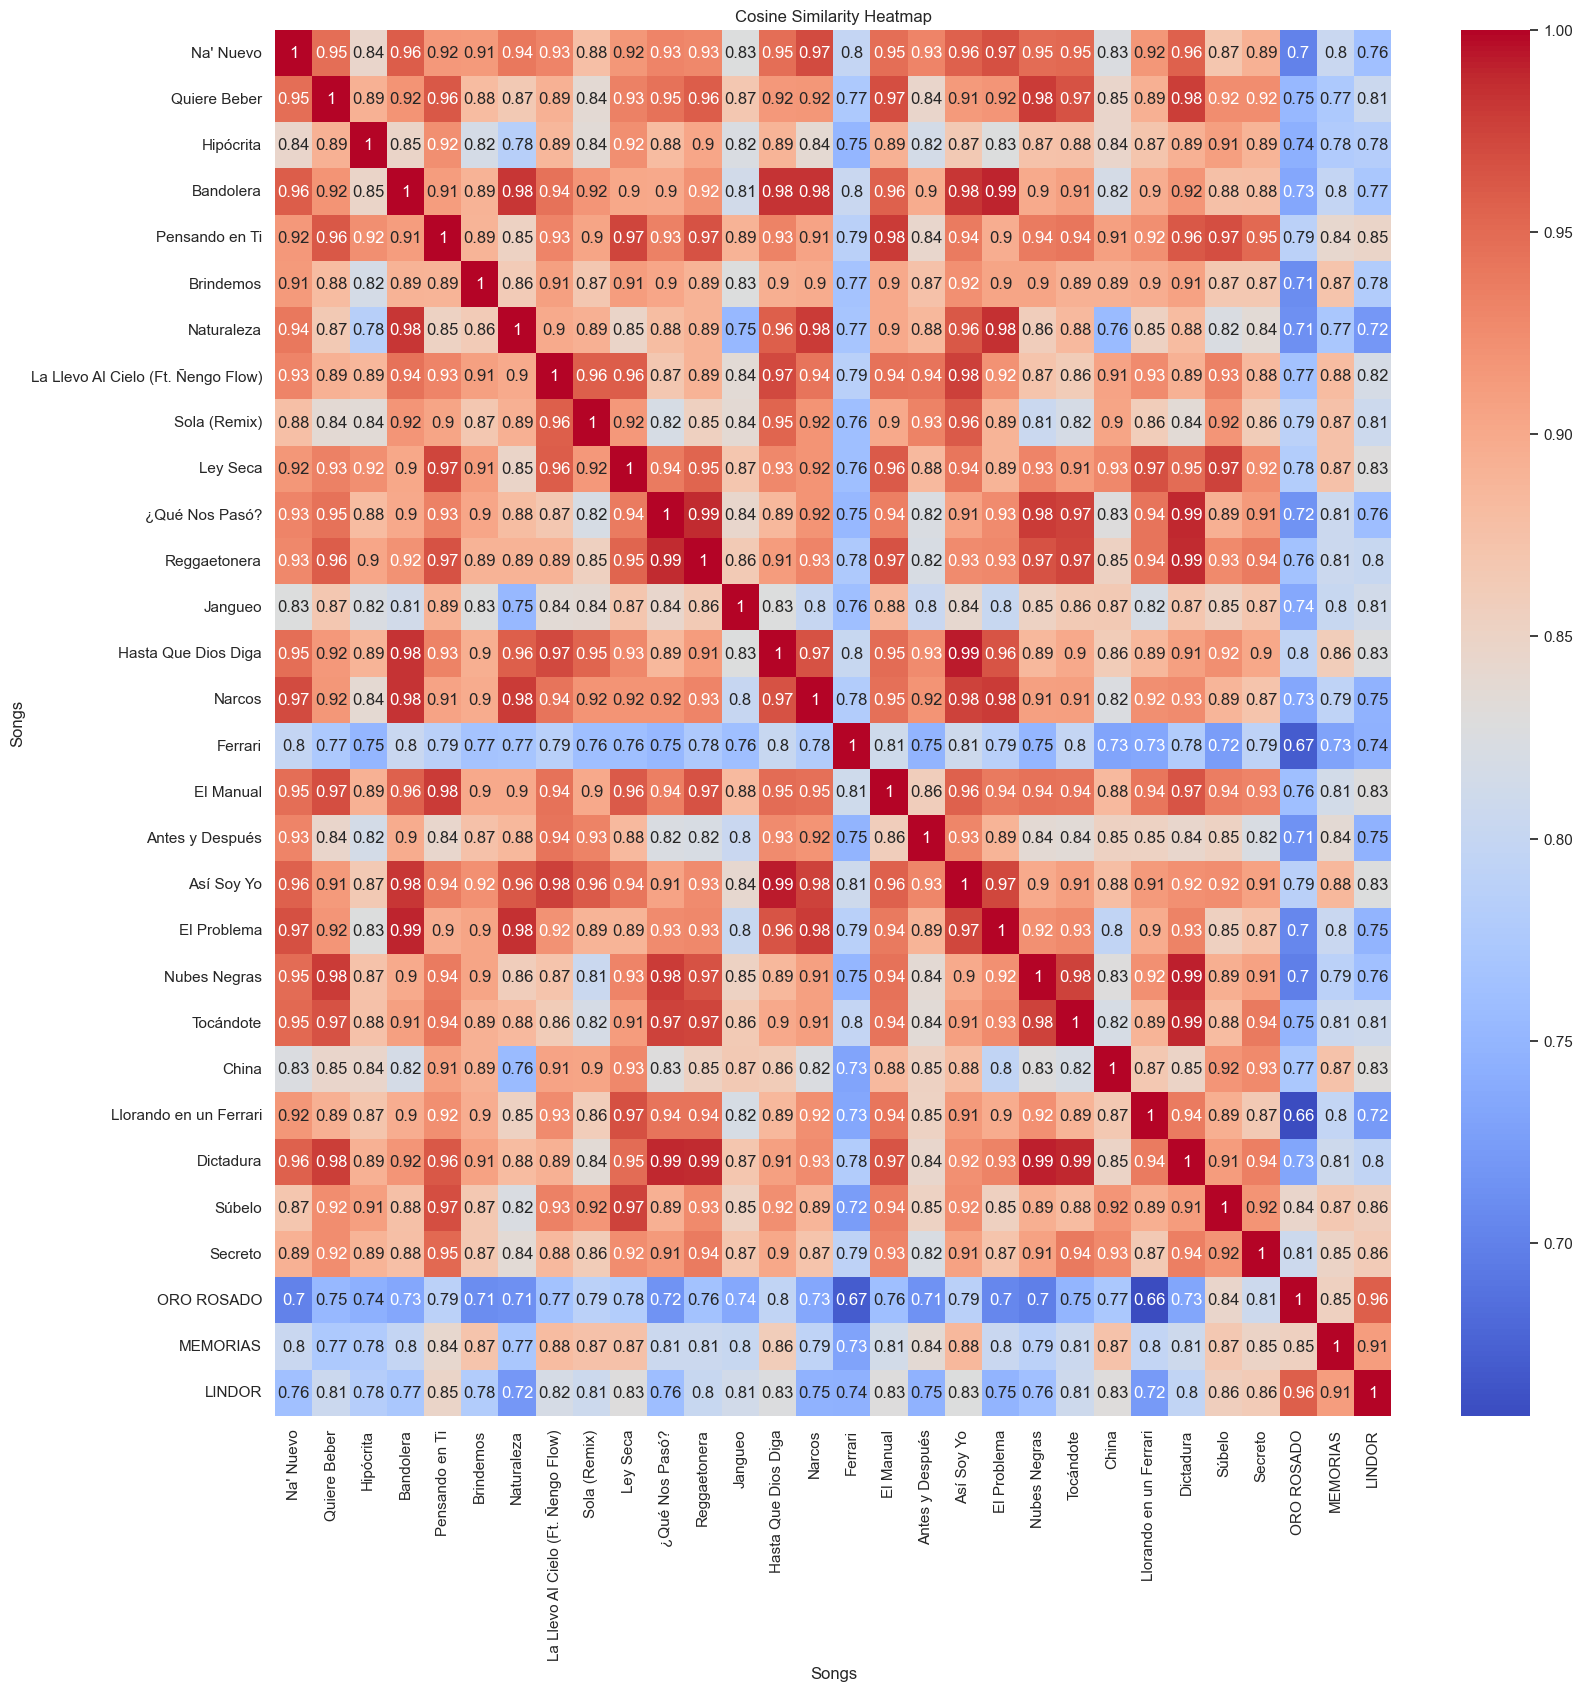

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in list(cosine_similarity_df.columns): #Need the columns in float to use in heatmap
    cosine_similarity_df[i] = cosine_similarity_df[i].astype(float)

cosine_similarity_df_heat_map = cosine_similarity_df.iloc[15:45, 15:45]


plt.figure(figsize=(18, 18))
sns.heatmap(cosine_similarity_df_heat_map, annot=True, cmap='coolwarm')

plt.title('Cosine Similarity Heatmap')
plt.xlabel('Songs')
plt.ylabel('Songs')

plt.show()


### Graph

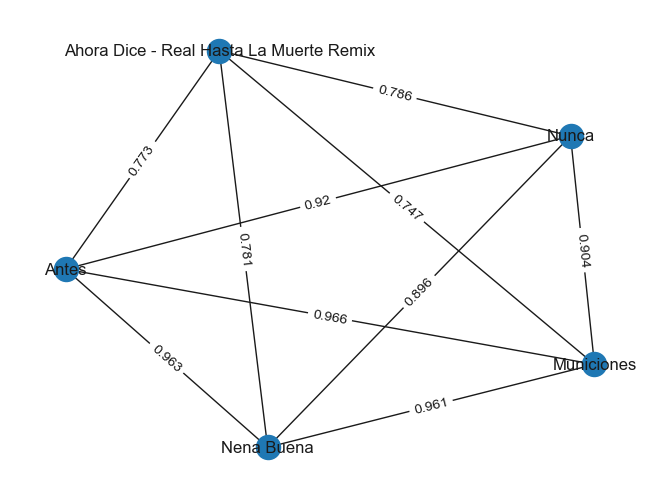

In [159]:
import networkx as nx

G = nx.Graph()
graph_df = cosine_similarity_df.iloc[10:15, 10:15]

num_songs = len(graph_df)
G.add_nodes_from(range(num_songs))


for i in range(num_songs):
    for j in range(i + 1, num_songs):
        similarity = round(graph_df.iloc[i,j], 3)
        G.add_edge(i, j, weight=similarity)

pos = nx.spring_layout(G)  
labels = {i: numb for i, numb in enumerate(graph_df.columns)}

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, labels=labels)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

### Count IMB genres

In [107]:
imb_genres = allSongs_feature_set[allSongs_feature_set['id'].isin(imb_id)].iloc[:,:-11]
topSpain_generes = allSongs_feature_set[allSongs_feature_set['id'].isin(topSpain_id)].iloc[:,:-11]
topGlobal_genres = allSongs_feature_set[allSongs_feature_set['id'].isin(topGlobal_id)].iloc[:,:-11]

In [112]:
count_genres = pd.DataFrame(index=list(imb_genres.columns), columns= ['IMB', 'topSpain', 'topGlobal'])
count_genres

,IMB,topSpain,topGlobal
_indie,NaN,NaN,NaN
adult_standards,NaN,NaN,NaN
alt_z,NaN,NaN,NaN
and,NaN,NaN,NaN
argentine_hip_hop,NaN,NaN,NaN
...,...,...,...
urbano_chileno,NaN,NaN,NaN
urbano_espanol,NaN,NaN,NaN
urbano_latino,NaN,NaN,NaN
venezuelan_hip_hop,NaN,NaN,NaN


In [114]:
count_genres.loc[:, 'IMB'] = list(imb_genres.sum(axis=0))
count_genres.loc[:, 'topSpain'] = list(topSpain_generes.sum(axis=0))
count_genres.loc[:, 'topGlobal'] = list(topGlobal_genres.sum(axis=0))
count_genres

,IMB,topSpain,topGlobal
_indie,0.000000,0.000000,1.718589
adult_standards,0.000000,0.000000,2.575610
alt_z,0.000000,0.000000,0.866029
and,0.000000,0.000000,0.415394
argentine_hip_hop,10.060767,0.707036,0.000000
...,...,...,...
urbano_chileno,1.242418,0.000000,0.000000
urbano_espanol,14.487667,7.374784,0.000000
urbano_latino,124.839247,13.361690,1.574208
venezuelan_hip_hop,0.440724,0.000000,0.000000


In [161]:
count_genres['IMB'].sort_values(ascending=False)

urbano_latino     124.839247
trap_latino       122.612520
reggaeton          98.588171
trap_boricua       44.375311
reggaeton_flow     35.604576
                     ...    
jazz_pop            0.000000
indie_folk          0.000000
gen_z_singer        0.000000
garage_rock         0.000000
vocal_jazz          0.000000
Name: IMB, Length: 148, dtype: float64

In [162]:
count_genres['topSpain'].sort_values(ascending=False)

urbano_latino           13.361690
trap_latino             12.974089
reggaeton                8.487782
urbano_espanol           7.374784
reggaeton_colombiano     5.266823
                          ...    
gen_z_singer             0.000000
garage_rock              0.000000
gangster_rap             0.000000
folktronica              0.000000
vocal_jazz               0.000000
Name: topSpain, Length: 148, dtype: float64

In [164]:
count_genres['topGlobal'].sort_values(ascending=False)

pop                   14.619782
canadian_pop           3.063176
rap                    2.927839
dance_pop              2.768154
adult_standards        2.575610
                        ...    
plugg                  0.000000
panamanian_pop         0.000000
pagode_baiano          0.000000
east_coast_hip_hop     0.000000
moombahton             0.000000
Name: topGlobal, Length: 148, dtype: float64

In [115]:
count_genres.to_csv('count_genres.csv', index=True)